In [ ]:
!pip install fastai
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from fastai.vision.all import *
from fastbook import *

In [ ]:
def search_images_ddg(key,max_n=200):
     """Search for 'key' with DuckDuckGo and return a unique urls of 'max_n' images
        (Adopted from https://github.com/deepanprabhu/duckduckgo-images-api)
     """
     url        = 'https://duckduckgo.com/'
     params     = {'q':key}
     res        = requests.post(url,data=params)
     searchObj  = re.search(r'vqd=([\d-]+)\&',res.text)
     if not searchObj: print('Token Parsing Failed !'); return
     requestUrl = url + 'i.js'
     headers    = {'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:71.0) Gecko/20100101 Firefox/71.0'}
     params     = (('l','us-en'),('o','json'),('q',key),('vqd',searchObj.group(1)),('f',',,,'),('p','1'),('v7exp','a'))
     urls       = []
     while True:
         try:
             res  = requests.get(requestUrl,headers=headers,params=params)
             data = json.loads(res.text)
             for obj in data['results']:
                 urls.append(obj['image'])
                 max_n = max_n - 1
                 if max_n < 1: return L(set(urls))     # dedupe
             if 'next' not in data: return L(set(urls))
             requestUrl = url + data['next']
         except:
             pass



In [ ]:
urls = search_images_ddg(u'grizzly bear', max_n=100)
len(urls), urls[0]

(100,
 'http://www.starfishcharters.com/files/6213/6036/8276/grizzly-bear-knight-inlet.jpg')

In [ ]:
Path('image').mkdir()

In [ ]:
print([name for name in os.listdir(".") if os.path.isdir(name)])

['.config', 'image', 'sample_data']


In [ ]:
path = Path(os.path.join(os.getcwd(),'image'))
Path.BASE_PATH = path

In [ ]:
category = 'mice', 'rat'
for c in category:
  p = (path/c)
  if not p.exists():
    p.mkdir()
  urls = search_images_ddg(c, max_n=100)
  print(urls[0])
  download_images(dest = p, urls = urls)
  print(len(os.listdir(p)))

https://insectcop.net/wp-content/uploads/2019/03/shutterstock_231790642-1-1024x683.jpg
107
http://images.victorpest.com/is/image/woodstream/vp-us-lc-library-norway-rat?$MediaPgLarge$
114


In [ ]:
fns = get_image_files(path)
fns

(#202) [Path('mice/00000013.jpg'),Path('mice/00000009.jpg'),Path('mice/00000097.jpg'),Path('mice/00000040.jpg'),Path('mice/00000052.jpg'),Path('mice/00000003.jpg'),Path('mice/00000021.jpg'),Path('mice/00000099.jpg'),Path('mice/00000053.jpg'),Path('mice/00000015.jpg')...]

In [ ]:
failed = verify_images(fns)
failed

(#2) [Path('mice/00000095.jpg'),Path('mice/00000075.jpg')]

In [ ]:
failed.map(Path.unlink)

(#2) [None,None]

In [ ]:
#create datablock
blocks = DataBlock(blocks = (ImageBlock, CategoryBlock),
                   get_items = get_image_files,
                   get_y = parent_label,
                   splitter = RandomSplitter(valid_pct=0.2, seed=42), 
                   item_tfms = Resize(128))
path = Path('/content/image')
dls = blocks.dataloaders(path)

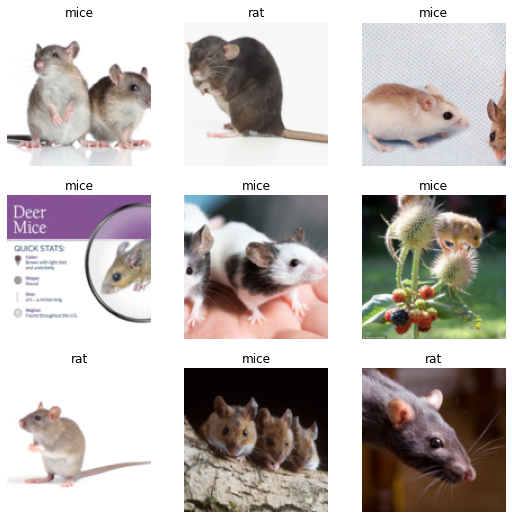

In [ ]:
dls.show_batch(max_n = 9, ncols = 3)

In [ ]:
blocks = blocks.new(item_tfms=RandomResizedCrop(224, min_scale=0.5), batch_tfms=aug_transforms())
dls = blocks.dataloaders(path)

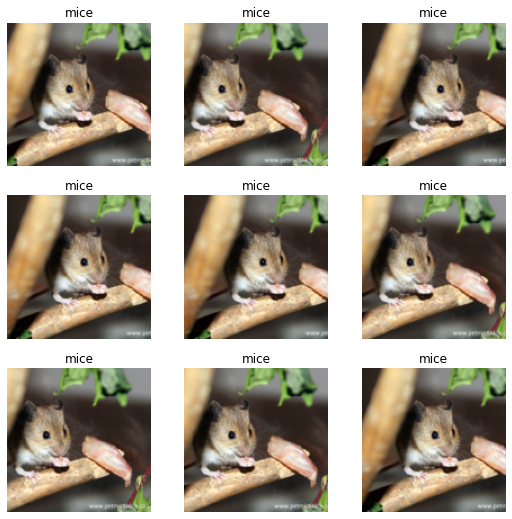

In [ ]:
dls.show_batch(unique=True)

In [ ]:
learner = cnn_learner(dls, resnet34, metrics=error_rate)
learner.fine_tune(10)

epoch,train_loss,valid_loss,error_rate,time
0,1.284408,1.472941,0.525000,00:04


epoch,train_loss,valid_loss,error_rate,time
0,0.983020,1.136176,0.475000,00:04
1,0.846820,1.030131,0.325000,00:05
2,0.737503,1.012131,0.300000,00:04
3,0.634278,0.840715,0.275000,00:04
4,0.535813,0.667868,0.175000,00:04
5,0.458957,0.657346,0.175000,00:05
6,0.413693,0.690346,0.250000,00:05
7,0.371644,0.714492,0.250000,00:04
8,0.333803,0.709098,0.250000,00:05
9,0.300257,0.698681,0.225000,00:05


In [ ]:
learner.dls = dls
learner.fine_tune(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.036936,0.012316,0.000000,00:05


epoch,train_loss,valid_loss,error_rate,time
0,0.036302,0.019692,0.000000,00:05


In [ ]:
interp = ClassificationInterpretation.from_learner(learner)

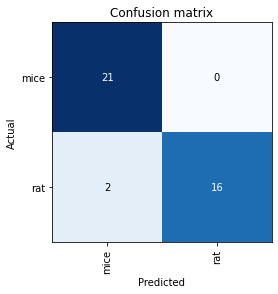

In [ ]:
interp.plot_confusion_matrix()

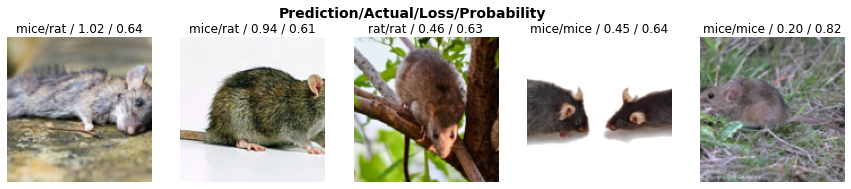

In [ ]:
interp.plot_top_losses(5, nrows=1)

In [ ]:
url = 'https://upload.wikimedia.org/wikipedia/commons/f/ff/Wistar_rat.jpg'
download_url(url, (path/'test.jpg'), chunk_size=128 )
img = Image.open(path/'test.jpg')

In [ ]:
img.thumbnail((256,256))
img

In [ ]:
learner.predict(path/'test.jpg')

In [ ]:
interp.top_losses(k=1)

(TensorBase([1.0171]), TensorBase([35]))

In [ ]:
test_dl = dls.valid_ds
items = test_dl.items
len(items)

39

In [ ]:
#handmade correction
f = items[35]
#if an image has to be deleted
f.unlink()
#if an image is not in the right category
# p = Path('/content/image/rat/correction.jpg')
# shutil.move(f, p)

In [ ]:
learner.export()